In [129]:
import plotly.express as px
from IPython.display import display
from ingest_stocks_to_df import ingest_stocks_to_df
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import pandas as pd
from itertools import cycle
from keras.layers import Dense, GRU
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing import timeseries_dataset_from_array

In [133]:

!python -m ipykernel install --user --name tensorflow_venv --display-name "Python tensorflow_venv"
import sys
print(sys.executable)

Installed kernelspec tensorflow_venv in /Users/admin/Library/Jupyter/kernels/tensorflow_venv
/Users/admin/miniconda3/bin/python


# data

In [106]:
stocks_str = 'GSIT'##'GSIT, ICAD, XAIR, LTRN, ARKK, ARKF, ARKW'
ticker_list = [ticker.strip() for ticker in stocks_str.upper().split(',')]
time_diff_years= 7
stocks_df = ingest_stocks_to_df(ticker_list=ticker_list, time_diff_years=time_diff_years)
display(stocks_df)
stock_names = ticker_list[0:3]
display(stock_names)
column_metric = 'Adj Close'

date    GSIT                                       
                         High    Low  Open   Close  Volume Adj Close
Date                                                                
2014-03-03 2014-03-03  6.8800  6.720  6.72  6.8800   34200    6.8800
2014-03-04 2014-03-04  7.1800  6.920  6.92  7.1600  209200    7.1600
2014-03-05 2014-03-05  7.2500  7.120  7.12  7.1900   40500    7.1900
2014-03-06 2014-03-06  7.2400  7.160  7.18  7.2000   14700    7.2000
2014-03-07 2014-03-07  7.2400  7.020  7.24  7.1400   25600    7.1400
...               ...     ...    ...   ...     ...     ...       ...
2021-02-24 2021-02-24  7.7600  7.500  7.76  7.5600   75600    7.5600
2021-02-25 2021-02-25  7.7900  7.460  7.61  7.6400  142600    7.6400
2021-02-26 2021-02-26  7.7700  7.340  7.76  7.3400   72700    7.3400
2021-03-01 2021-03-01  7.7700  7.440  7.46  7.6700  117000    7.6700
2021-03-02 2021-03-02  7.7781  7.585  7.61  7.6799   39848    7.6799

[1763 rows x 7 columns]

['GSIT']

# visualization

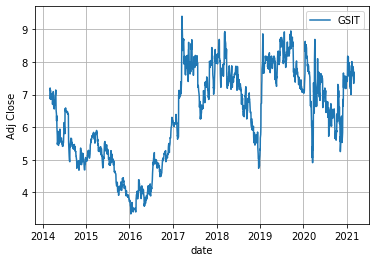

In [107]:
# display(stocks_df.columns)
indecies =  [*zip(stock_names, cycle([column_metric]))]
fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel(column_metric)
ax.grid()
for index in indecies:
    ax = sns.lineplot(data=stocks_df, x='date', y=index, ax=ax, label=index[0])
plt.show()

# fit

In [117]:
class KerasPreprocess:
    def __init__():
        pass
    @classmethod
    def keras_batch_preprocess(cls, stocks_df, company_name, metric, lookback_length=60, batch_size=60):
        column_list = cls.get_column_list(stocks_df, company_name, metric)
        data, targets = cls.get_data_targets_split(column_list, lookback_length=lookback_length)
        data_train, data_val, data_test = cls.train_val_test_split(data)
        targets_train, targets_val, targets_test = cls.train_val_test_split(targets)
        train_ds = timeseries_dataset_from_array(data=data_train, targets=targets_train, sequence_length=lookback_length, batch_size=batch_size)
        val_ds = timeseries_dataset_from_array(data=data_val, targets=targets_val, sequence_length=lookback_length, batch_size=batch_size)
        test_ds = timeseries_dataset_from_array(data=data_test, targets=targets_test, sequence_length=lookback_length, batch_size=batch_size)
        return train_ds, val_ds, test_ds
    @staticmethod
    def get_column_list(stocks_df, company_name, metric):
        column_slice = stocks_df[company_name, metric]
        column_list = column_slice.tolist()
        return column_list
    @staticmethod
    def get_data_targets_split(column_list, lookback_length=lookback_length):
        data = np.array([[x] for x in column_list[:-lookback_length]])
        targets = np.array([y for y in column_list[lookback_length:]])
        return data, targets
    @staticmethod
    def train_val_test_split(data, test_size=0.2):
        test_length = int(len(data)*test_size)
        train_length = 1 - 2*test_length
        train = data[:train_length]
        val = data[train_length:train_length+test_length]
        test = data[-test_length:]
        return train, val, test

class PreprocessingXY:    
    @classmethod
    def preprocess(cls, stocks_df, company_name, metric, lookback_length=60):
        column_list = cls.get_column_list(stocks_df, company_name, metric)
        x, y = cls.to_xy_timeseries(column_list, lookback_length=lookback_length)
        x_train, x_test, y_train, y_test = cls.xy_train_test_split(x, y, test_size=0.2)
        x_train, x_test, y_train, y_test = [cls.batch_reshape(d) for d in [x_train, x_test, y_train, y_test]]
        return x_train, x_test, y_train, y_test
    @staticmethod
    def get_column_list(stocks_df, company_name, metric):
        column_slice = stocks_df[company_name, metric]
        column_list = column_slice.tolist()
        return column_list
    @staticmethod
    def to_xy_timeseries(column_list, lookback_length=60):
        x, y = list(),list()
        for index in range(lookback_length, len(column_list)):
            x.append(column_list[index-lookback_length:index])
            y.append(column_list[index])
        x = np.array(x)
        y = np.array(y)
        return x, y
    @classmethod
    def xy_train_val_test_split(cls, x, y, test_size=0.2, lookback_length=60):
        x_train, x_val, x_test = cls.train_val_test_split(x, test_size=test_size)
        y_train, y_val, y_test = cls.train_val_test_split(y, test_size=test_size)
        timeseries_dataset_from_array(x=x_train, y=y_train)
        return
    @staticmethod
    def train_test_split(data, test_size=0.2):
        test_length = int(len(data)*test_size)
        train_length = 1 - test_length
        train = data[:train_length]
        test = data[-test_length:]
        return train, test
    @classmethod
    def xy_train_test_split(cls,x, y, test_size=0.2):
        x_train, x_test = cls.train_test_split(x, test_size=test_size)
        y_train, y_test = cls.train_test_split(y, test_size=test_size)
        return x_train, x_test, y_train, y_test
    @staticmethod
    def batch_reshape(np_array):
        reshaped = np_array.reshape(1, *np_array.shape)
        return reshaped

In [109]:
class ModelFit:
    def __init__(self):
        pass
    @staticmethod
    def gru_model(nodes=50, dropout=0.0, recurrent_dropout=0.0, learning_rate=0.01, loss='mse', optimizer=Adam, metrics=['mse']):
        model = Sequential()
        model.add(GRU(nodes))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=loss,
                  metrics=metrics)
        return model
    @classmethod
    def train_model(cls, train_data=None, validation_data=None, model=None):
        early_stop = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
        model = cls.gru_model()
        history = model.fit(train_data, validation_data=validation_data, callbacks=[early_stop], epochs=300)
        return history, model
    @staticmethod
    def evaluate_model(model,test_data):
        model.evaluate(test_data)

In [124]:
metric = 'Adj Close'
company_name = 'GSIT'
lookback_length=40
batch_size=30

train_ds, val_ds, test_ds = KerasPreprocess.keras_batch_preprocess(stocks_df, company_name, metric, lookback_length=lookback_length, batch_size=batch_size)

mf = ModelFit
model=mf.gru_model()
history, model = mf.train_model(train_data=train_ds, validation_data=val_ds, model=model)

test_error = mf.evaluate_model(model, test_ds)

train_error = pd.DataFrame(history.history)
display(train_error)

,loss,mse,val_loss,val_mse
0,4.791694,4.791694,1.160597,1.160597
1,2.623149,2.623149,1.049412,1.049412
2,3.402533,3.402533,0.655733,0.655733
3,2.707311,2.707311,0.668347,0.668347
4,2.402601,2.402601,0.624572,0.624572
5,2.408549,2.408549,0.581923,0.581923
6,2.246649,2.246649,0.571008,0.571008
7,2.128481,2.128481,0.545694,0.545694
8,1.868984,1.868984,0.522349,0.522349
9,1.600875,1.600875,0.519804,0.519804
